# Token Efficiency Analysis: Muon vs Multiscale

Simplified analysis with sliding window averaging (window=20)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [20]:
def parse_test_losses(filepath):
    """Extract test losses with their token counts."""
    data = []
    
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    
    for i, line in enumerate(lines):
        if line.strip().startswith('Test loss:'):
            try:
                test_loss = float(line.split(':')[1].strip())
                # Get tokens from next line
                if i + 1 < len(lines):
                    match = re.search(r'\[(\d+)\].*Tokens: (\d+)', lines[i + 1])
                    if match:
                        step = int(match.group(1))
                        tokens = int(match.group(2))
                        data.append({
                            'step': step,
                            'tokens': tokens,
                            'test_loss': test_loss
                        })
            except:
                continue
    
    df = pd.DataFrame(data)
    return df.sort_values('tokens').reset_index(drop=True)

In [21]:
# Parse logs and filter to 1B-5B range
muon_df = parse_test_losses('downloaded_logs/muon_lr0.025_run1_20250808_205949.log')
multiscale_df = parse_test_losses('downloaded_logs/multiscale_lr0.025_run1_20250808_205949.log')

muon = muon_df[(muon_df['tokens'] >= 1e9) & (muon_df['tokens'] <= 5e9)].copy().reset_index(drop=True)
multiscale = multiscale_df[(multiscale_df['tokens'] >= 1e9) & (multiscale_df['tokens'] <= 5e9)].copy().reset_index(drop=True)

# Apply sliding window averaging
window = 50
muon['smooth_loss'] = muon['test_loss'].rolling(window=window, center=True, min_periods=1).mean()
multiscale['smooth_loss'] = multiscale['test_loss'].rolling(window=window, center=True, min_periods=1).mean()

print(f"Data points in 1B-5B range - Muon: {len(muon)}, Multiscale: {len(multiscale)}")
print(f"Applied sliding window averaging (window={window})")

Data points in 1B-5B range - Muon: 814, Multiscale: 814
Applied sliding window averaging (window=50)


In [22]:
# Calculate multiplicative factors
def find_first_matching_muon(muon_df, target_loss):
    """Find the first muon point that reaches or beats the target loss."""
    matching = muon_df[muon_df['smooth_loss'] <= target_loss]
    if len(matching) > 0:
        return matching.iloc[0]['tokens']
    return None

factors = []
valid_tokens = []

for idx, row in multiscale.iterrows():
    multiscale_tokens = row['tokens']
    multiscale_loss = row['smooth_loss']
    
    muon_tokens = find_first_matching_muon(muon, multiscale_loss)
    
    if muon_tokens is not None and multiscale_tokens > 0:
        factor = muon_tokens / multiscale_tokens
        factors.append(factor)
        valid_tokens.append(multiscale_tokens)

# Calculate geometric mean
factors_arr = np.array(factors)
tokens_arr = np.array(valid_tokens)
geometric_mean = np.exp(np.mean(np.log(factors_arr)))

print(f"\nCalculated {len(factors)} multiplicative factors")
print(f"Geometric mean: {geometric_mean:.4f}x")


Calculated 712 multiplicative factors
Geometric mean: 1.1132x


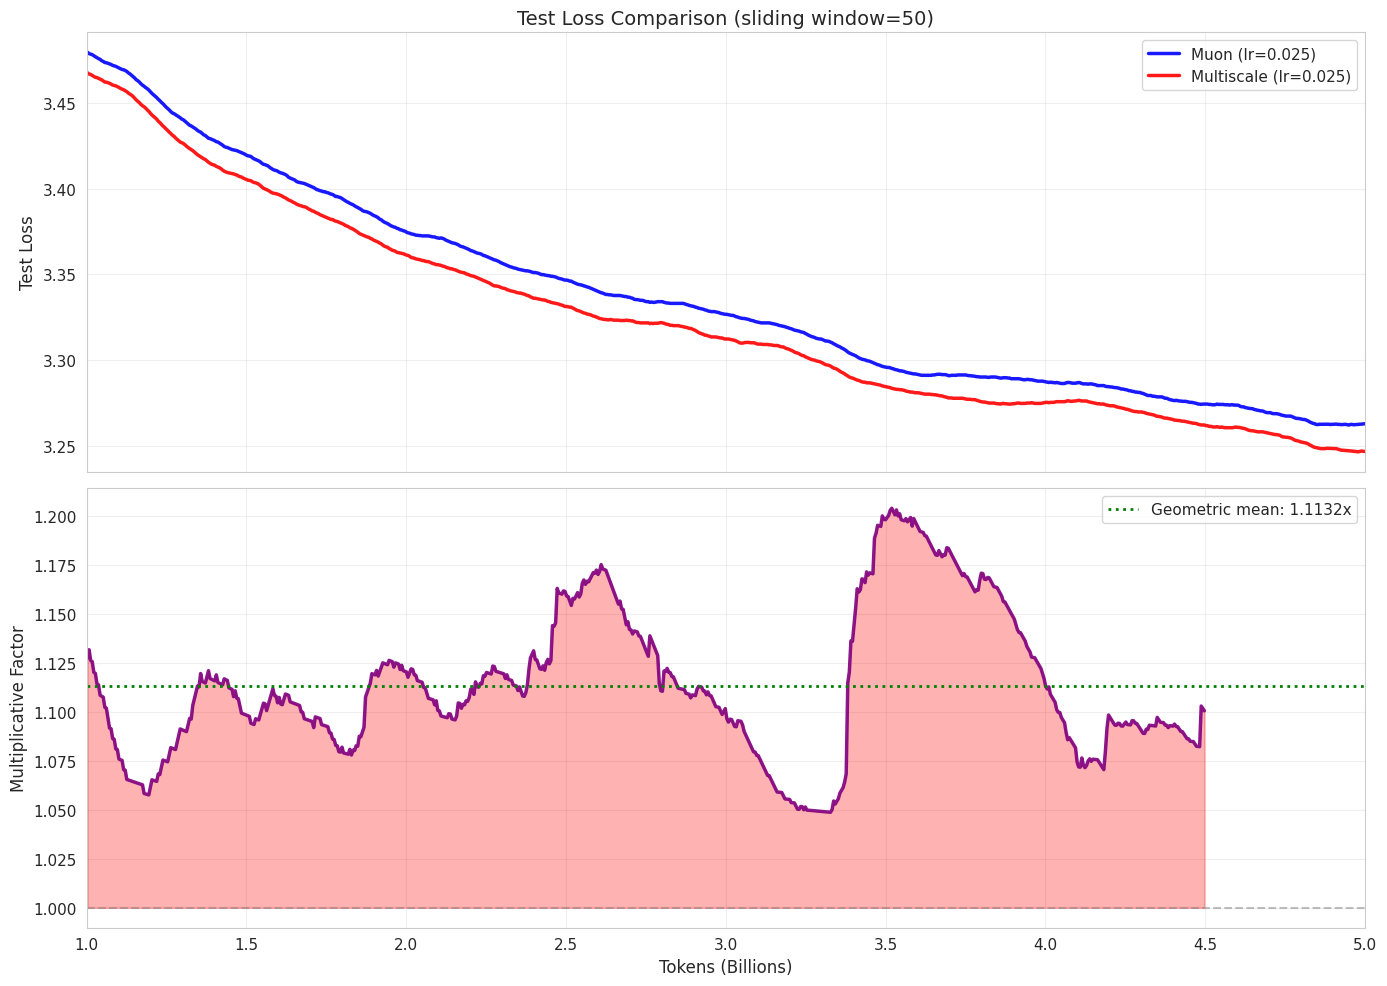

In [23]:
# Create combined visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top: Test losses
ax1.plot(muon['tokens']/1e9, muon['smooth_loss'],
         'b-', linewidth=2.5, label='Muon (lr=0.025)', alpha=0.9)
ax1.plot(multiscale['tokens']/1e9, multiscale['smooth_loss'],
         'r-', linewidth=2.5, label='Multiscale (lr=0.025)', alpha=0.9)

ax1.set_ylabel('Test Loss', fontsize=12)
ax1.set_title(f'Test Loss Comparison (sliding window={window})', fontsize=14)
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom: Token efficiency
ax2.plot(tokens_arr/1e9, factors_arr,
         'purple', linewidth=2.5, alpha=0.9)
ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.axhline(y=geometric_mean, color='green', linestyle=':', linewidth=2,
            label=f'Geometric mean: {geometric_mean:.4f}x')
ax2.fill_between(tokens_arr/1e9, 1.0, factors_arr,
                 where=(factors_arr > 1.0), alpha=0.3, color='red')
ax2.fill_between(tokens_arr/1e9, 1.0, factors_arr,
                 where=(factors_arr <= 1.0), alpha=0.3, color='green')

ax2.set_xlabel('Tokens (Billions)', fontsize=12)
ax2.set_ylabel('Multiplicative Factor', fontsize=12)
ax2.set_xlim(1, 5)
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Summary statistics
print("="*60)
print("TOKEN EFFICIENCY SUMMARY")
print("="*60)
print(f"\nGeometric mean: {geometric_mean:.4f}x")
print(f"Interpretation: Muon needs {geometric_mean:.4f}x as many tokens")
print(f"as Multiscale to achieve the same test loss.")
print(f"\nDetailed statistics:")
print(f"  Min factor: {factors_arr.min():.4f}x")
print(f"  Max factor: {factors_arr.max():.4f}x")
print(f"  Median: {np.median(factors_arr):.4f}x")
print(f"  Std dev: {np.std(factors_arr):.4f}")

# Check at specific milestones
milestones = [1e9, 2e9, 3e9, 4e9, 5e9]
print("\nLoss comparison at token milestones:")
print("-"*40)
for milestone in milestones:
    muon_idx = np.argmin(np.abs(muon['tokens'].values - milestone))
    multiscale_idx = np.argmin(np.abs(multiscale['tokens'].values - milestone))
    
    if muon_idx < len(muon) and multiscale_idx < len(multiscale):
        muon_loss = muon.iloc[muon_idx]['smooth_loss']
        multiscale_loss = multiscale.iloc[multiscale_idx]['smooth_loss']
        print(f"{milestone/1e9:.0f}B tokens: Muon={muon_loss:.4f}, Multiscale={multiscale_loss:.4f}, Δ={muon_loss-multiscale_loss:.4f}")

TOKEN EFFICIENCY SUMMARY

Geometric mean: 1.1132x
Interpretation: Muon needs 1.1132x as many tokens
as Multiscale to achieve the same test loss.

Detailed statistics:
  Min factor: 1.0487x
  Max factor: 1.2039x
  Median: 1.1084x
  Std dev: 0.0372

Loss comparison at token milestones:
----------------------------------------
1B tokens: Muon=3.4796, Multiscale=3.4676, Δ=0.0120
2B tokens: Muon=3.3746, Multiscale=3.3612, Δ=0.0134
3B tokens: Muon=3.3266, Multiscale=3.3122, Δ=0.0144
4B tokens: Muon=3.2872, Multiscale=3.2752, Δ=0.0120
5B tokens: Muon=3.2627, Multiscale=3.2465, Δ=0.0162
